# Mid Price Forecast Using Order Book Features
The following notebook implements the research on the BTC mid price change forecast using the order book data. The purpose of the study is to check whether the different features calculated from the order book can be useful for forecasting future mid price movement.

The notebook uses the preprocessed order book data. The preprocessing was done in the separate C++ project (https://github.com/beforeyougo/TDigitalTestTask/tree/main/OrderBook) where the order book features were calculated.

The main part of the study is to use the Random Forest model to identify whether the features can predict the mid price or not. The Random Forest model was chosen because of following reasons:
1. It is not guaranteed the the dependence of the mid price on features is linear. Random Forest is a good way to take into account non-linear patterns.
2. Random Forest is resistant to overfitting. We want to protect ourselves from the case when we have chosen good features, but the result on the test sample is poor because of overfitting.
3. Out-of-bag error can be used to validate the model hyperparameters. Hence, there is no need to allocate an extra sample for validation.
4. After model is validated and tested, we can use feature importance to determine whether we need all extracted features.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import operator as op
import itertools as itr
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from tqdm.notebook import tqdm


plt.style.use('ggplot')

# 1. Load the data
We load the preprocessed dataset and immediately reorganize it calculating the Volume Weighted Price Standard Deviation from the correspondig first and second moments.

In [3]:
orderBookData = pd.read_csv('../OrderBook/OrderBook/results/results.csv')

orderBookData.TimeStamp /= 1e9
orderBookData.TimeStamp = orderBookData.TimeStamp.apply(datetime.datetime.fromtimestamp)
orderBookData.index = orderBookData.TimeStamp
orderBookData = orderBookData.drop('TimeStamp', axis=1)

orderBookData = orderBookData.assign(MidPrice = 0.5 * (orderBookData.BestBid + orderBookData.BestAsk))
orderBookData = orderBookData.drop(['BestBid', 'BestAsk'], axis=1)

orderBookData = orderBookData.assign(VolumeWeightedPriceStd = np.sqrt(orderBookData.VolumeWeightedAverageSquaredPrice - 
                                     np.square(orderBookData.VolumeWeightedAveragePrice)),
                                     BidVolumeWeightedPriceStd = np.sqrt(orderBookData.BidVolumeWeightedAverageSquaredPrice - 
                                     np.square(orderBookData.BidVolumeWeightedAveragePrice)),
                                     AskVolumeWeightedPriceStd = np.sqrt(orderBookData.AskVolumeWeightedAverageSquaredPrice - 
                                     np.square(orderBookData.AskVolumeWeightedAveragePrice)))
orderBookData = orderBookData.drop(['VolumeWeightedAverageSquaredPrice',
                                    'BidVolumeWeightedAverageSquaredPrice',
                                    'AskVolumeWeightedAverageSquaredPrice'], axis=1)


orderBookData.head()

,AverageVolume,BidAverageVolume,AskAverageVolume,VolumeWeightedAveragePrice,BidVolumeWeightedAveragePrice,AskVolumeWeightedAveragePrice,VolumeImbalance,DollarImbalance,MidPrice,VolumeWeightedPriceStd,BidVolumeWeightedPriceStd,AskVolumeWeightedPriceStd
TimeStamp,,,,,,,,,,,,
2022-02-01 03:00:02.434877,3.79053,5.03042,2.89284,36401.1,31985.5,41960.2,0.114645,0.403804,38485.0,7220.105179,5447.732533,4995.159253
2022-02-01 03:00:02.434923,3.79078,5.03059,2.89315,36401.2,31985.8,41959.8,0.114609,0.403803,38485.0,7220.293523,5446.888870,4995.516386
2022-02-01 03:00:02.436127,3.80049,5.03034,2.91008,36415.5,31985.5,41959.8,0.111705,0.401364,38485.0,7216.048763,5446.814643,4979.476274
2022-02-01 03:00:02.436137,3.80066,5.03074,2.91008,36415.6,31986.0,41959.8,0.111744,0.401364,38485.0,7215.544099,5447.550275,4979.476274
2022-02-01 03:00:02.496460,3.79964,5.02838,2.91003,36415.1,31982.9,41959.8,0.111522,0.401363,38485.0,7216.681508,5447.394569,4979.476274


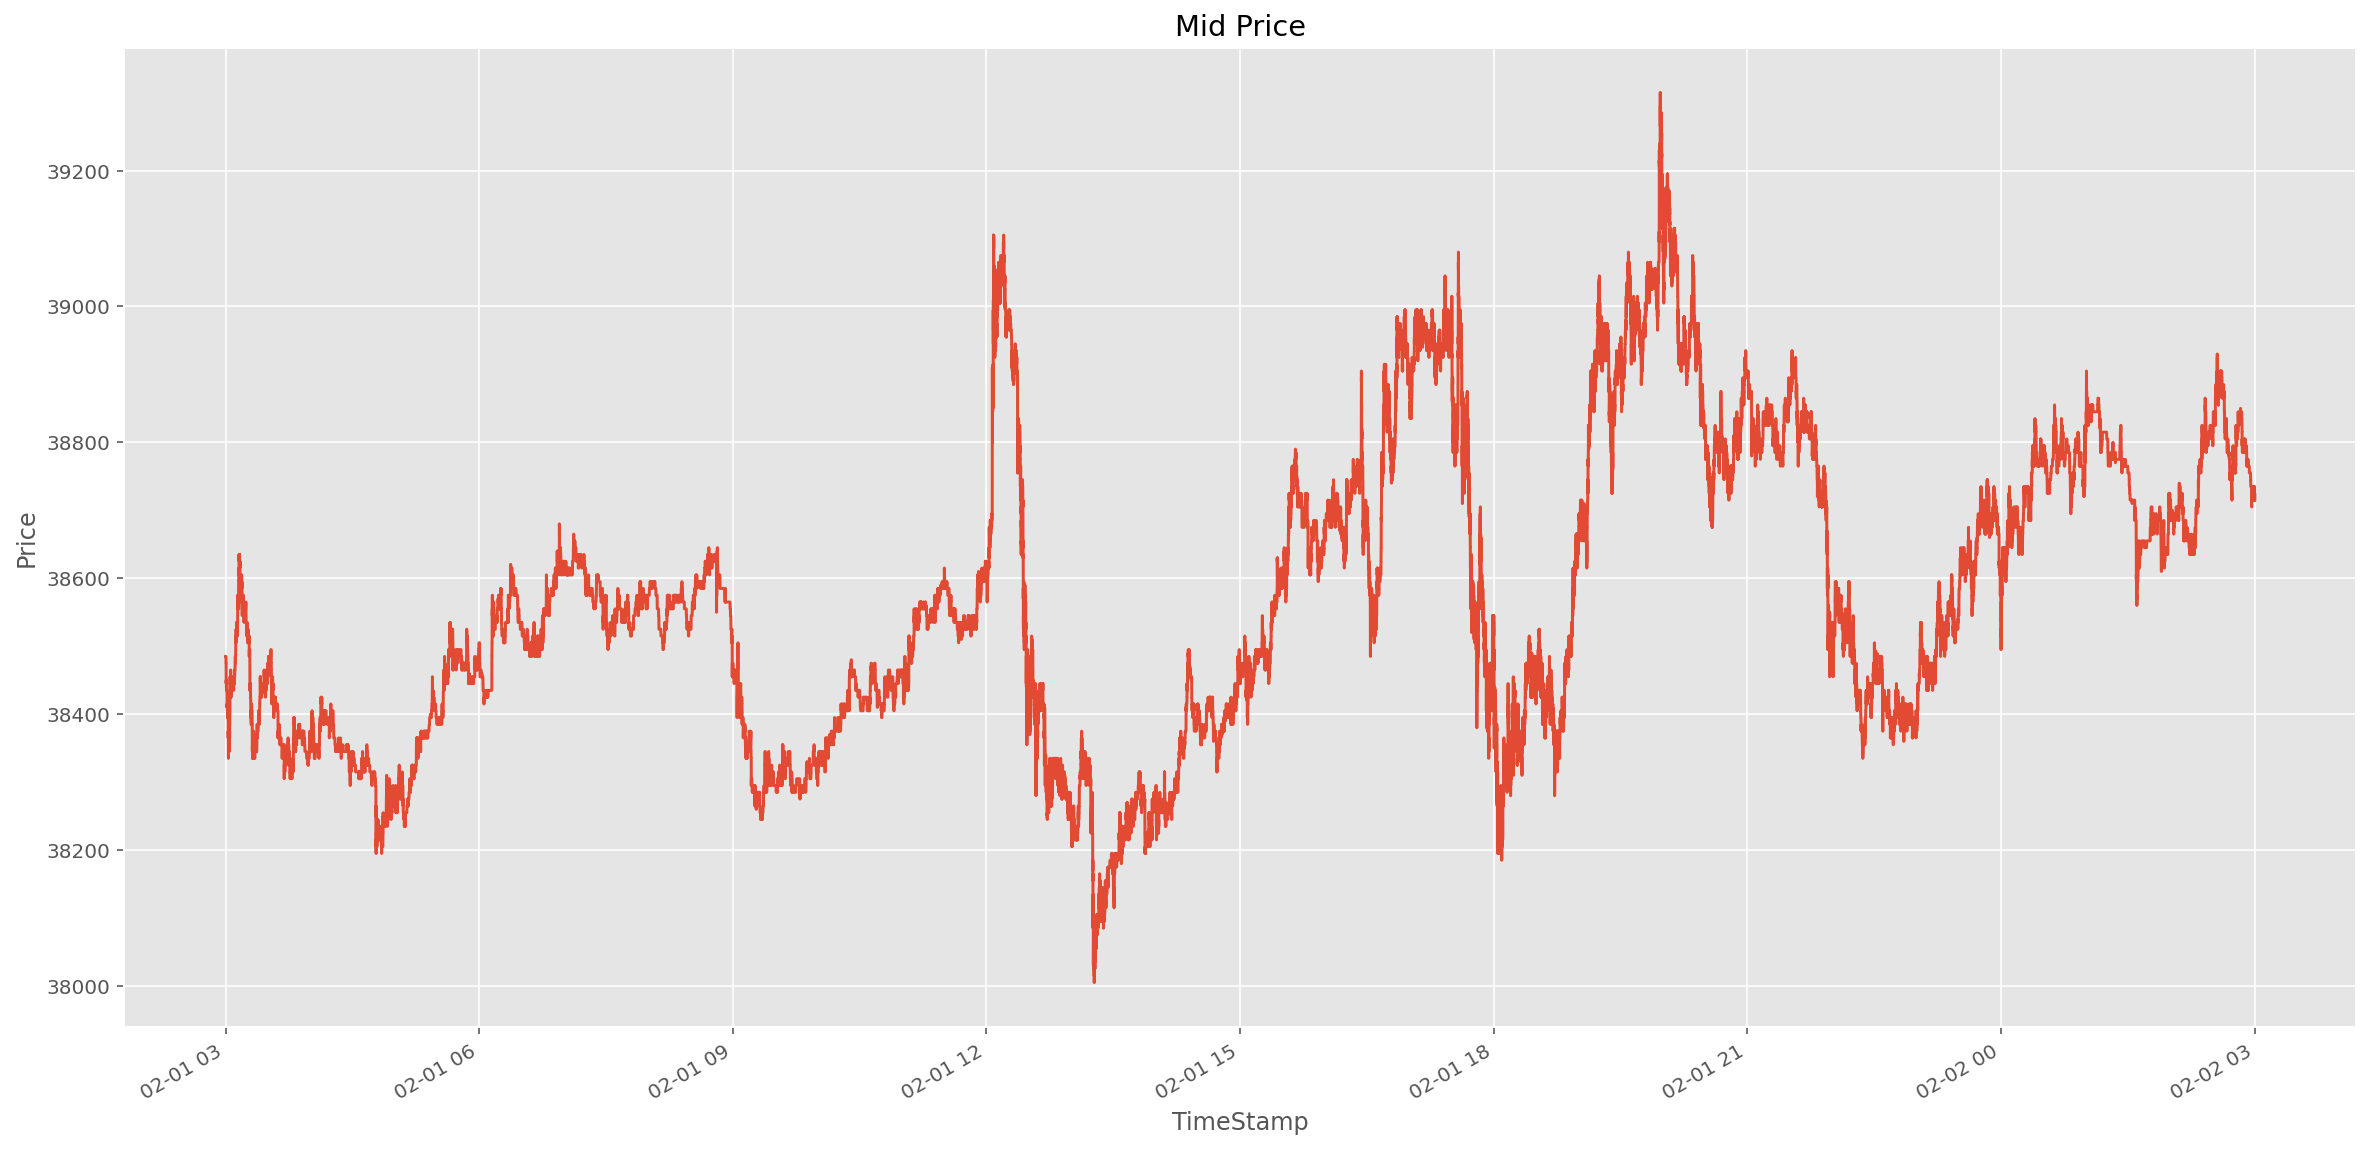

In [4]:
orderBookData.MidPrice.plot(figsize=(20, 10))
plt.title('Mid Price')
plt.ylabel('Price')
plt.show()

# 2. Elementary analysis of data correlation
We look at the raw data and see whether it contains of highly correlated features. First of all, we focus on the features that are calulated for the whole order book and for bids and ask separately. It might be that we don't need extra information.

Such analysis is a bit dirty because the data at this moment is not a time series yet because time intervals between points are different. And even it was a time series, we could not guarantee that series are stationary. But we just want to get rid of duplicated features if they are. In this case, the end justifies the means.

In [5]:
orderBookData.corr()

,AverageVolume,BidAverageVolume,AskAverageVolume,VolumeWeightedAveragePrice,BidVolumeWeightedAveragePrice,AskVolumeWeightedAveragePrice,VolumeImbalance,DollarImbalance,MidPrice,VolumeWeightedPriceStd,BidVolumeWeightedPriceStd,AskVolumeWeightedPriceStd
AverageVolume,1.000000,0.649265,0.956756,0.728986,-0.364682,-0.231686,-0.881976,-0.846884,-0.493100,-0.408870,-0.406948,-0.489559
BidAverageVolume,0.649265,1.000000,0.404317,0.025363,-0.056770,-0.638563,-0.247158,-0.330124,-0.725755,-0.494960,-0.788181,-0.388135
AskAverageVolume,0.956756,0.404317,1.000000,0.861150,-0.450094,-0.056859,-0.976513,-0.910347,-0.356866,-0.296802,-0.213017,-0.432568
VolumeWeightedAveragePrice,0.728986,0.025363,0.861150,1.000000,-0.198924,0.426511,-0.884114,-0.853596,0.043270,0.014683,0.179430,-0.186315
BidVolumeWeightedAveragePrice,-0.364682,-0.056770,-0.450094,-0.198924,1.000000,0.268183,0.542448,0.502253,0.531670,0.240796,0.353332,0.326695
AskVolumeWeightedAveragePrice,-0.231686,-0.638563,-0.056859,0.426511,0.268183,1.000000,-0.011104,-0.088411,0.706152,0.480931,0.636549,0.309217
VolumeImbalance,-0.881976,-0.247158,-0.976513,-0.884114,0.542448,-0.011104,1.000000,0.930384,0.327109,0.206779,0.124266,0.367471
DollarImbalance,-0.846884,-0.330124,-0.910347,-0.853596,0.502253,-0.088411,0.930384,1.000000,0.464253,0.167105,0.273746,0.316620
MidPrice,-0.493100,-0.725755,-0.356866,0.043270,0.531670,0.706152,0.327109,0.464253,1.000000,0.419165,0.854246,0.338289
VolumeWeightedPriceStd,-0.408870,-0.494960,-0.296802,0.014683,0.240796,0.480931,0.206779,0.167105,0.419165,1.000000,0.503264,0.967947


Let's denote the '&' sign as 'is highly correlated' and '!&' as 'not highly correlated'

1. AverageVolume & BidAverageVolume, AskAverageVolume; BidAverageVolume !& AskAverageVolume => remove AverageVolume
2. VolumeWeightedPriceStd & BidVolumeWeightedPriceStd, AskVolumeWeightedPriceStd;   
   BidVolumeWeightedPriceStd !& AskVolumeWeightedPriceStd => remove VolumeWeightedPriceStd
3. VolumeImbalance & DollarImbalance => remove VolumeImbalance

In [6]:
dropFeatures = ['AverageVolume', 'VolumeImbalance', 'VolumeWeightedPriceStd']
orderBookData.drop(dropFeatures, axis=1).corr()

,BidAverageVolume,AskAverageVolume,VolumeWeightedAveragePrice,BidVolumeWeightedAveragePrice,AskVolumeWeightedAveragePrice,DollarImbalance,MidPrice,BidVolumeWeightedPriceStd,AskVolumeWeightedPriceStd
BidAverageVolume,1.000000,0.404317,0.025363,-0.056770,-0.638563,-0.330124,-0.725755,-0.788181,-0.388135
AskAverageVolume,0.404317,1.000000,0.861150,-0.450094,-0.056859,-0.910347,-0.356866,-0.213017,-0.432568
VolumeWeightedAveragePrice,0.025363,0.861150,1.000000,-0.198924,0.426511,-0.853596,0.043270,0.179430,-0.186315
BidVolumeWeightedAveragePrice,-0.056770,-0.450094,-0.198924,1.000000,0.268183,0.502253,0.531670,0.353332,0.326695
AskVolumeWeightedAveragePrice,-0.638563,-0.056859,0.426511,0.268183,1.000000,-0.088411,0.706152,0.636549,0.309217
DollarImbalance,-0.330124,-0.910347,-0.853596,0.502253,-0.088411,1.000000,0.464253,0.273746,0.316620
MidPrice,-0.725755,-0.356866,0.043270,0.531670,0.706152,0.464253,1.000000,0.854246,0.338289
BidVolumeWeightedPriceStd,-0.788181,-0.213017,0.179430,0.353332,0.636549,0.273746,0.854246,1.000000,0.388978
AskVolumeWeightedPriceStd,-0.388135,-0.432568,-0.186315,0.326695,0.309217,0.316620,0.338289,0.388978,1.000000


In [7]:
orderBookData = orderBookData.drop(dropFeatures, axis=1)

# 3. Validate and test the model on diffrent time periods
We will use different time horizons to evaluate the forecasting power of the features:
1. 300 milliseconds
2. 1 second
3. 5 seconds
4. 30 seconds
5. 1 minute


For each time period, we will resample the raw data in correspondig time bars.
We will predict the relative mid price change: $\ln{\frac{P_{t + dt}}{P_t}}$. Hence it is natural to use change of our features at current moment of time instead of their absolute values. We will use absolute change for average volumes and relative change for average prices and prices standatd deviations. The Dollar Imbalance indicator is kept untouched.

For each time period, we validate three major hyperparameters of the Random Forest model:
1. Number of estimators
2. Minimal number of samples in the leaf
3. Max depth of the tree

Validation is done via choosing the best R2 score on the out-of-bag sample

After validation is done, we evaluate the R2 score of the trained model on the testing dataset. If the score is good, we can conclude that the predictive power of all features in the aggregate is statistically significant. Then we can look at the feature importance and try to identify which feature can be discarded.

In [14]:
features = ['BAV_d', 'AAV_d', 'VWAP_rd', 'BVWAP_rd', 'AWAP_rd',
            'MidPrice_rd', 'BVWPStd_rd', 'AVWPStd_rd', 'DollarImbalance']

n_estimators = [50, 100, 150, 200]
min_samples_leaf = [2, 4, 6]
max_depth = [4, 6, 8]

# cast it to list to see tqdm animatio
grid = list(itr.product(n_estimators, min_samples_leaf, max_depth))

def validate_model_for_timedelta(timedelta):
    resampled_df = orderBookData.resample(timedelta).agg('last')
    resampled_df.fillna(method='pad', inplace=True)
    resampled_df = resampled_df.assign(BAV_d = resampled_df.BidAverageVolume.diff(),
                                       AAV_d = resampled_df.AskAverageVolume.diff(),
                                       VWAP_rd = np.log(resampled_df.VolumeWeightedAveragePrice).diff(),
                                       BVWAP_rd = np.log(resampled_df.BidVolumeWeightedAveragePrice).diff(),
                                       AWAP_rd = np.log(resampled_df.AskVolumeWeightedAveragePrice).diff(),
                                       MidPrice_rd = np.log(resampled_df.MidPrice).diff(),
                                       BVWPStd_rd = np.log(resampled_df.BidVolumeWeightedPriceStd).diff(),
                                       AVWPStd_rd = np.log(resampled_df.AskVolumeWeightedPriceStd).diff())
    resampled_df = resampled_df.assign(MidPrice_rd_next = resampled_df.MidPrice_rd.shift(-1))
    resampled_df.dropna(inplace=True)
    
    X = resampled_df[features].values
    Y = resampled_df.MidPrice_rd_next.values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

    res = dict()

    model = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=42, n_jobs=-1)

    for prms in tqdm(grid):
        model.set_params(n_estimators=prms[0], min_samples_leaf=prms[1], max_depth=prms[2])
        model.fit(X_train, Y_train)
        res.update({prms:model.oob_score_})

    prms = max(res.items(), key=lambda item: item[-1])[0]
    model.set_params(n_estimators=prms[0], min_samples_leaf=prms[1], max_depth=prms[2])
    model.fit(X_train, Y_train)
    
    return model, resampled_df, X_train, X_test, Y_train, Y_test

labels = ["x%s"%i for i in range(1, 10)]
legend = "\n".join(["x%s = %s"%(i + 1, feature) for i, feature in enumerate(features)])

def plot_results_for_validated_model(validation_res, timedelta, first_elements=300):
    model, resampled_df, X_train, X_test, Y_train, Y_test = validation_res
    y_frcst = model.predict(X_test)
    
    plt.rcParams['font.size'] = 15
    fig, ax = plt.subplots(1, 2, figsize=(30, 12))
    
    y_test_plot = Y_test[:first_elements]
    y_frcst_plot = y_frcst[:first_elements]
    index_plot = resampled_df.index[Y_train.size:Y_train.size + first_elements]
    ax[0].plot(index_plot, y_test_plot, label='Real values')
    ax[0].plot(index_plot, y_frcst_plot, label='Forecasted values')
    ax[0].set_title("First %s forecasted values for test data\n"
                    "R2 score of train data = %s\n"
                    "R2 score on test data = %s"%
                    (index_plot.size, round(model.score(X_train, Y_train), 4), round(model.score(X_test, Y_test), 4)),
                    size=25)
    ax[0].set_xlabel("Time", size=20)
    ax[0].set_ylabel("Mid price relative change after dt=%s"%timedelta, size=20)
    ax[0].legend()

    ax[1].bar(labels, model.feature_importances_, label=legend)
    ax[1].set_title("Feature importance", size=25)
    ax[1].legend()

    plt.show()

## 300 milliseconds

  0%|          | 0/36 [00:00<?, ?it/s]

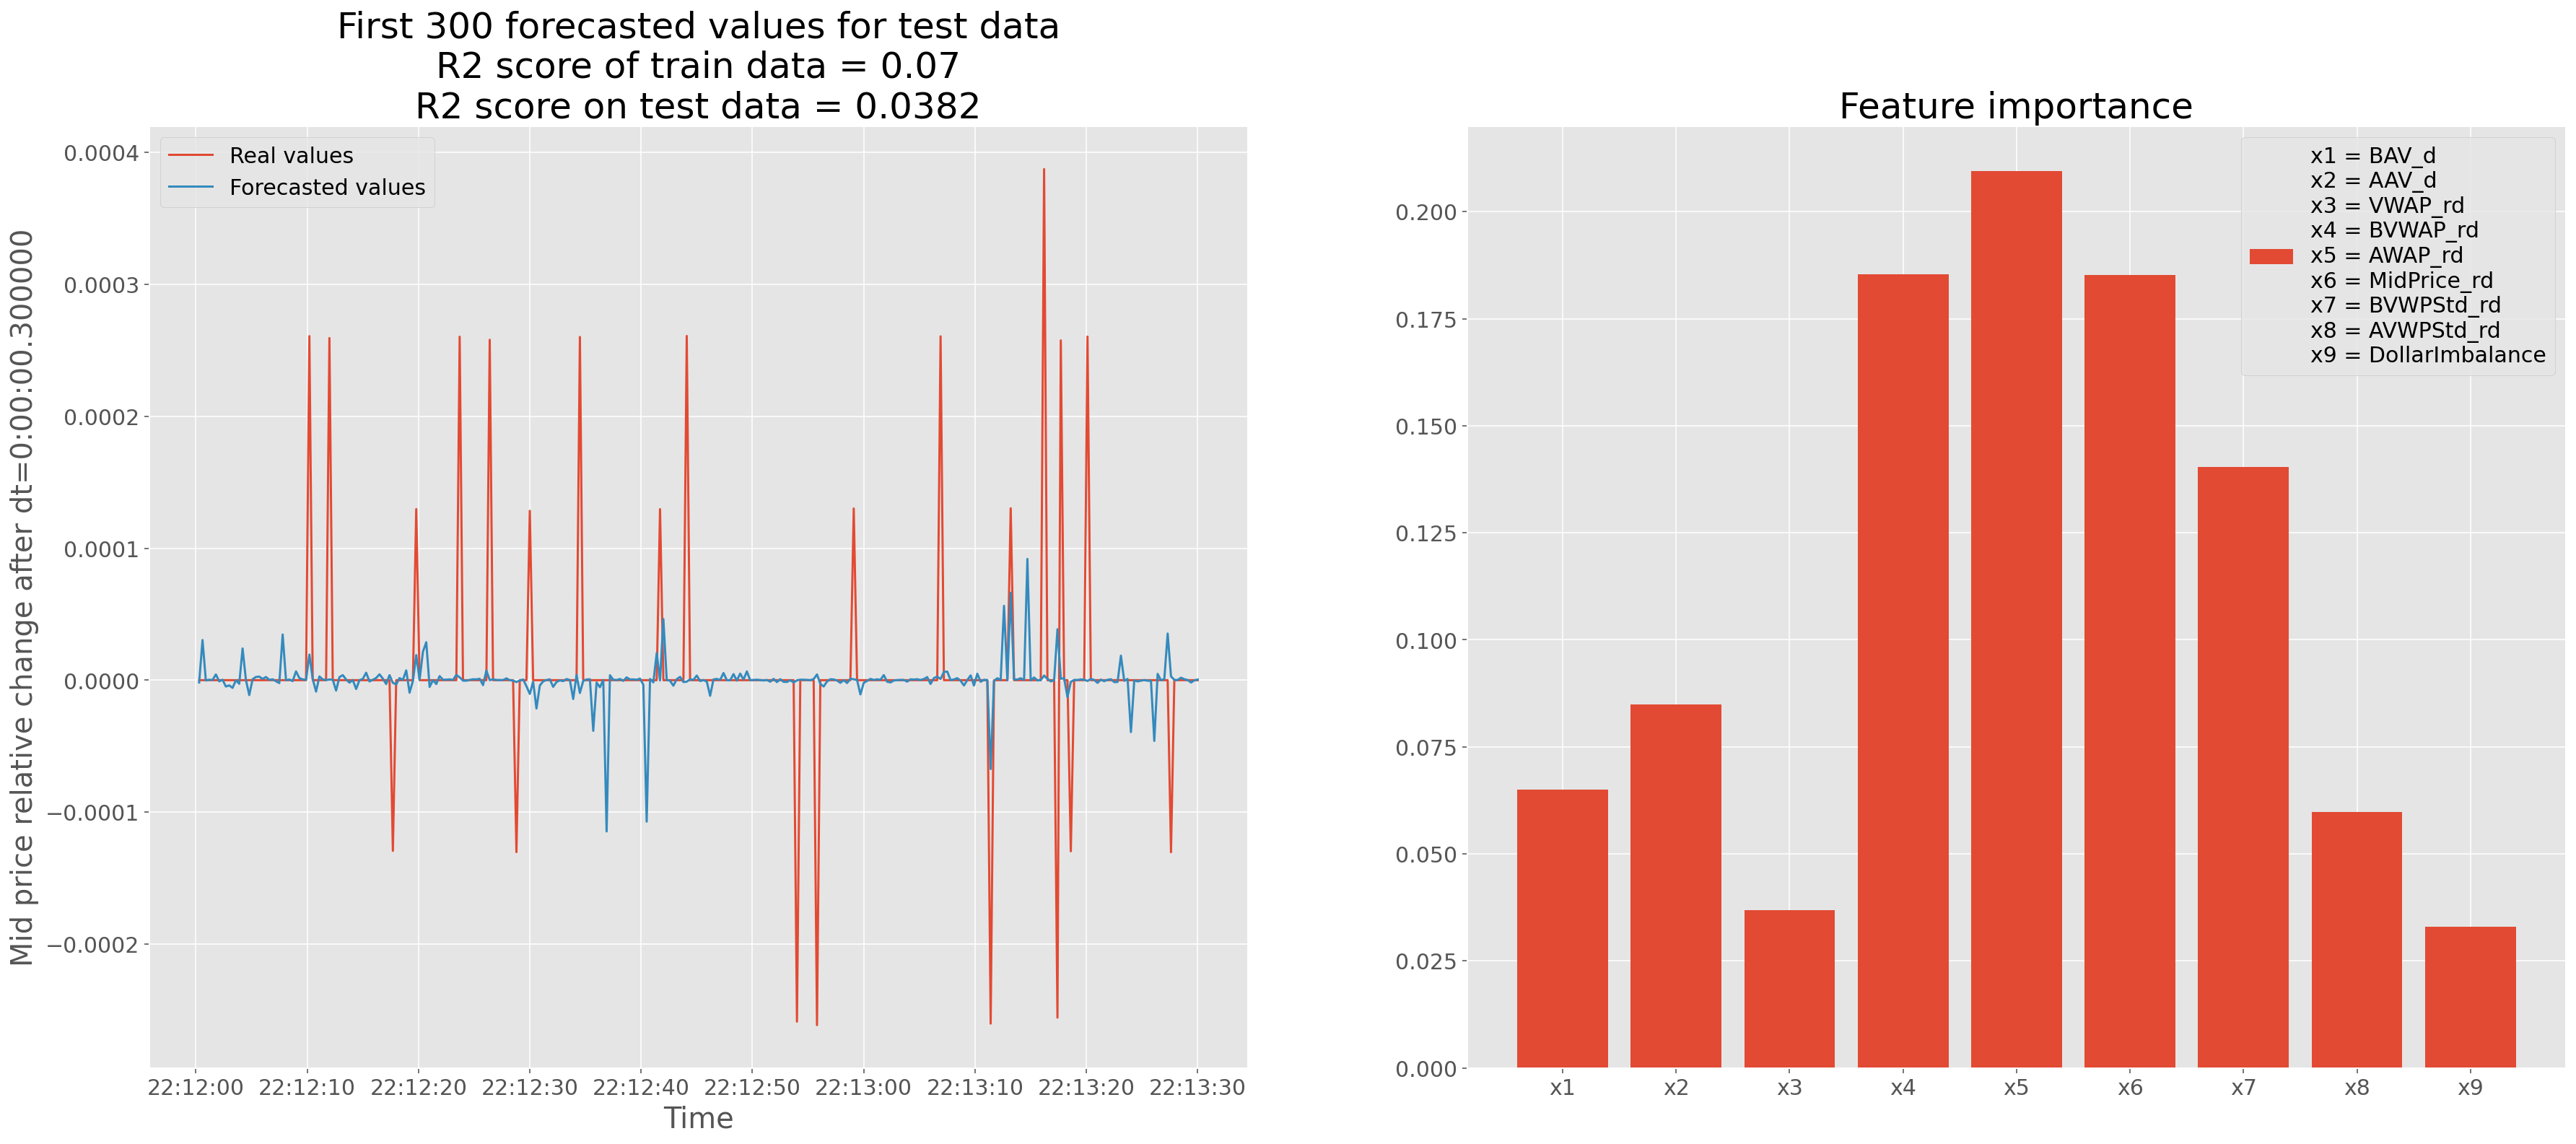

In [15]:
timedelta = datetime.timedelta(milliseconds=300)
validation_res = validate_model_for_timedelta(timedelta)
plot_results_for_validated_model(validation_res, timedelta)

## 1 second

  0%|          | 0/36 [00:00<?, ?it/s]

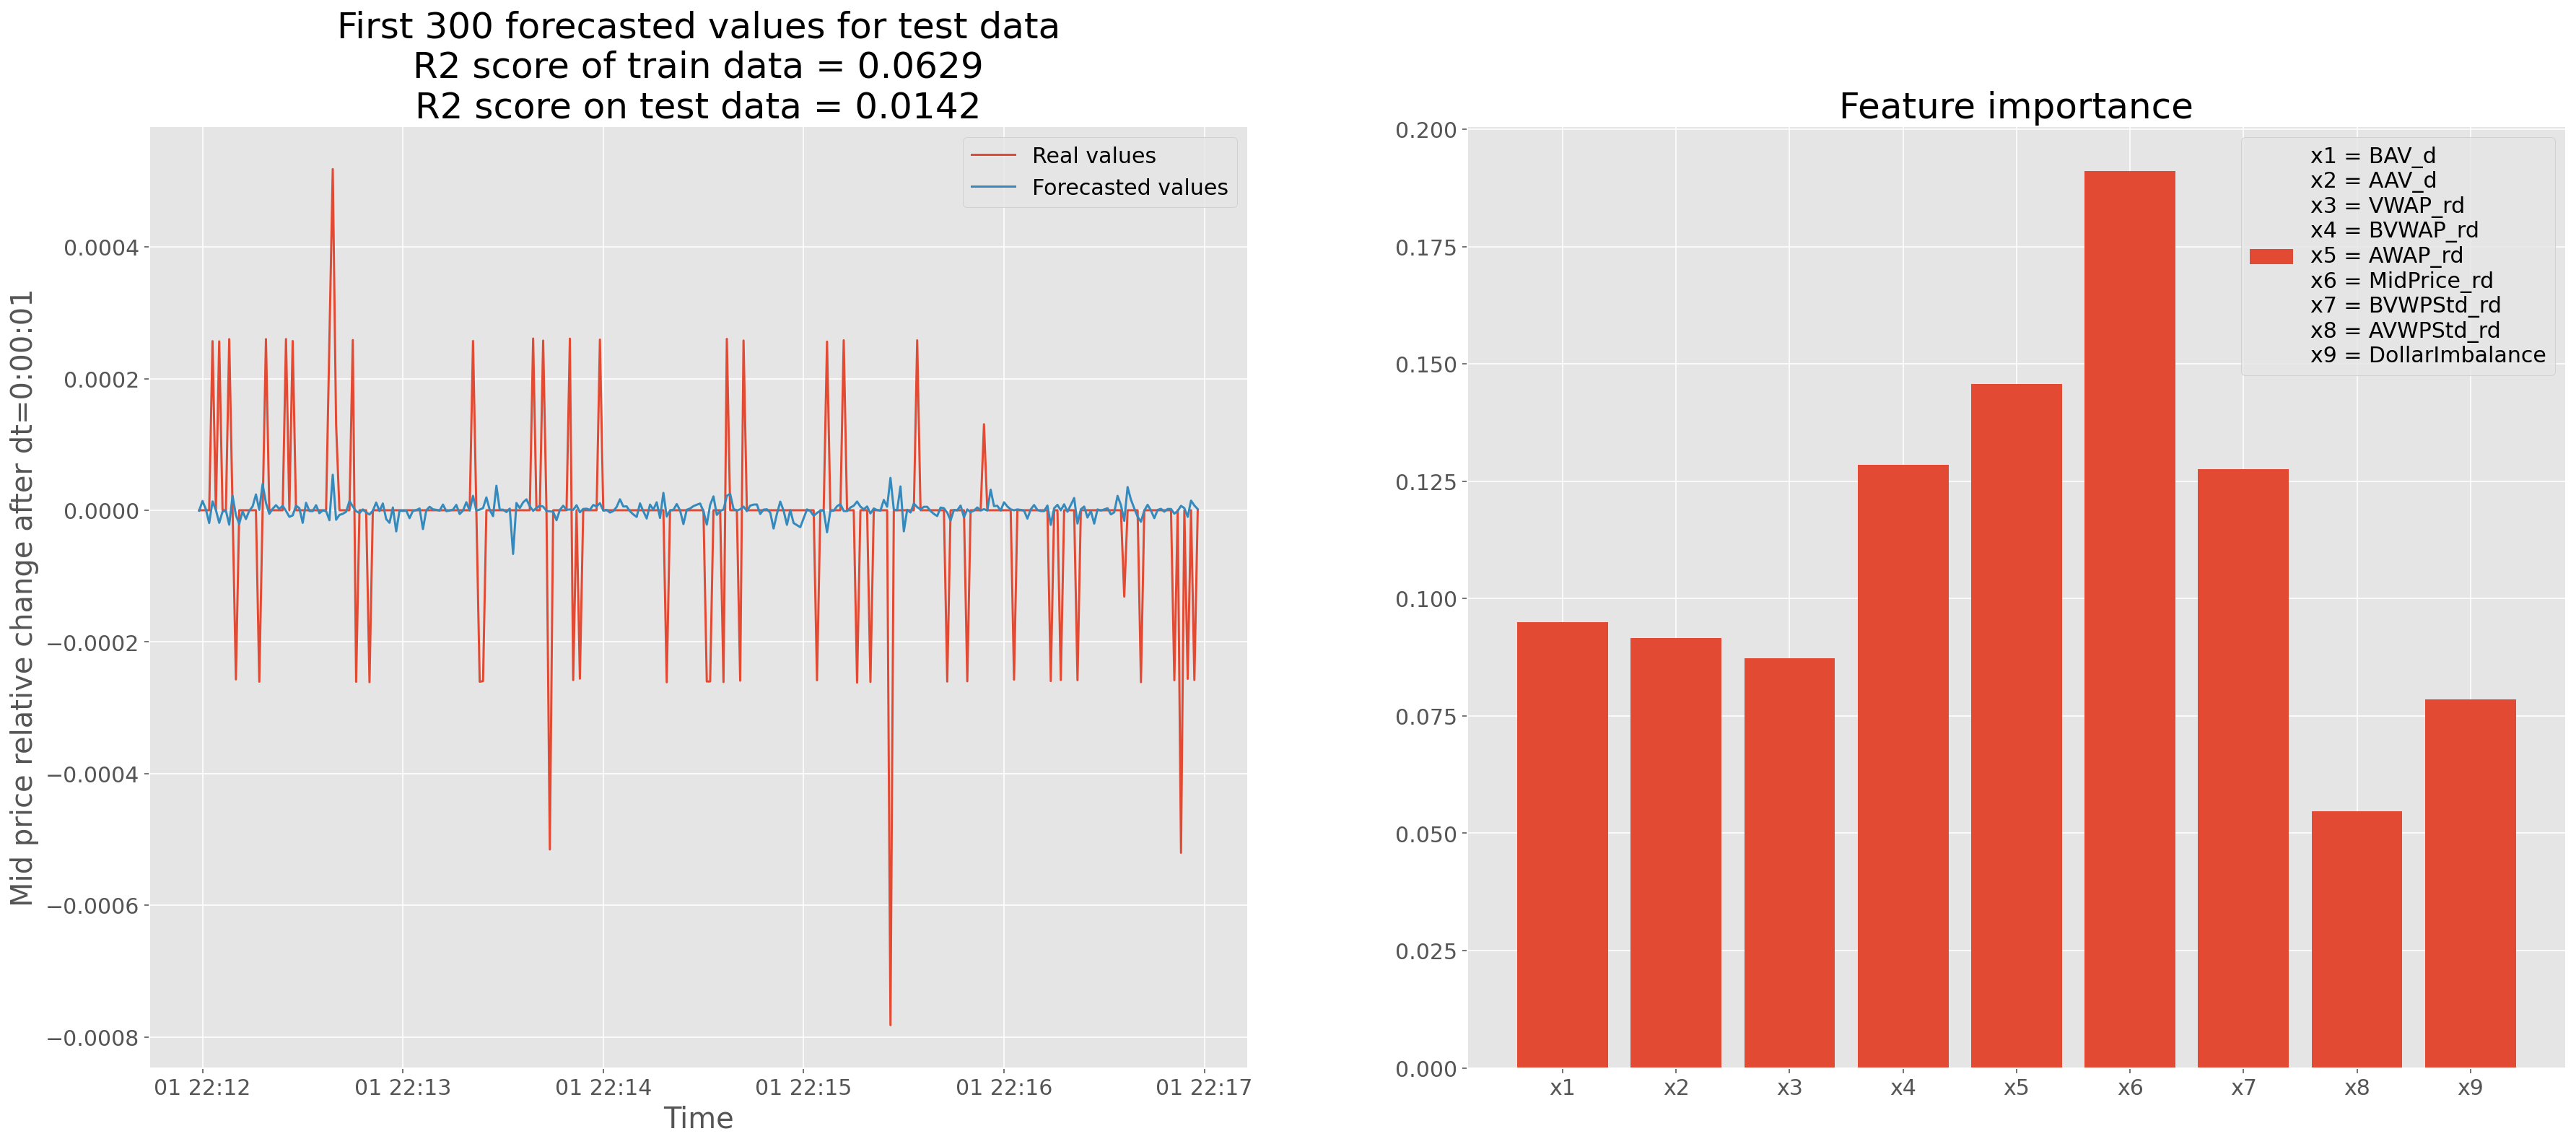

In [16]:
timedelta = datetime.timedelta(seconds=1)
validation_res = validate_model_for_timedelta(timedelta)
plot_results_for_validated_model(validation_res, timedelta)

## 5 seconds

  0%|          | 0/36 [00:00<?, ?it/s]

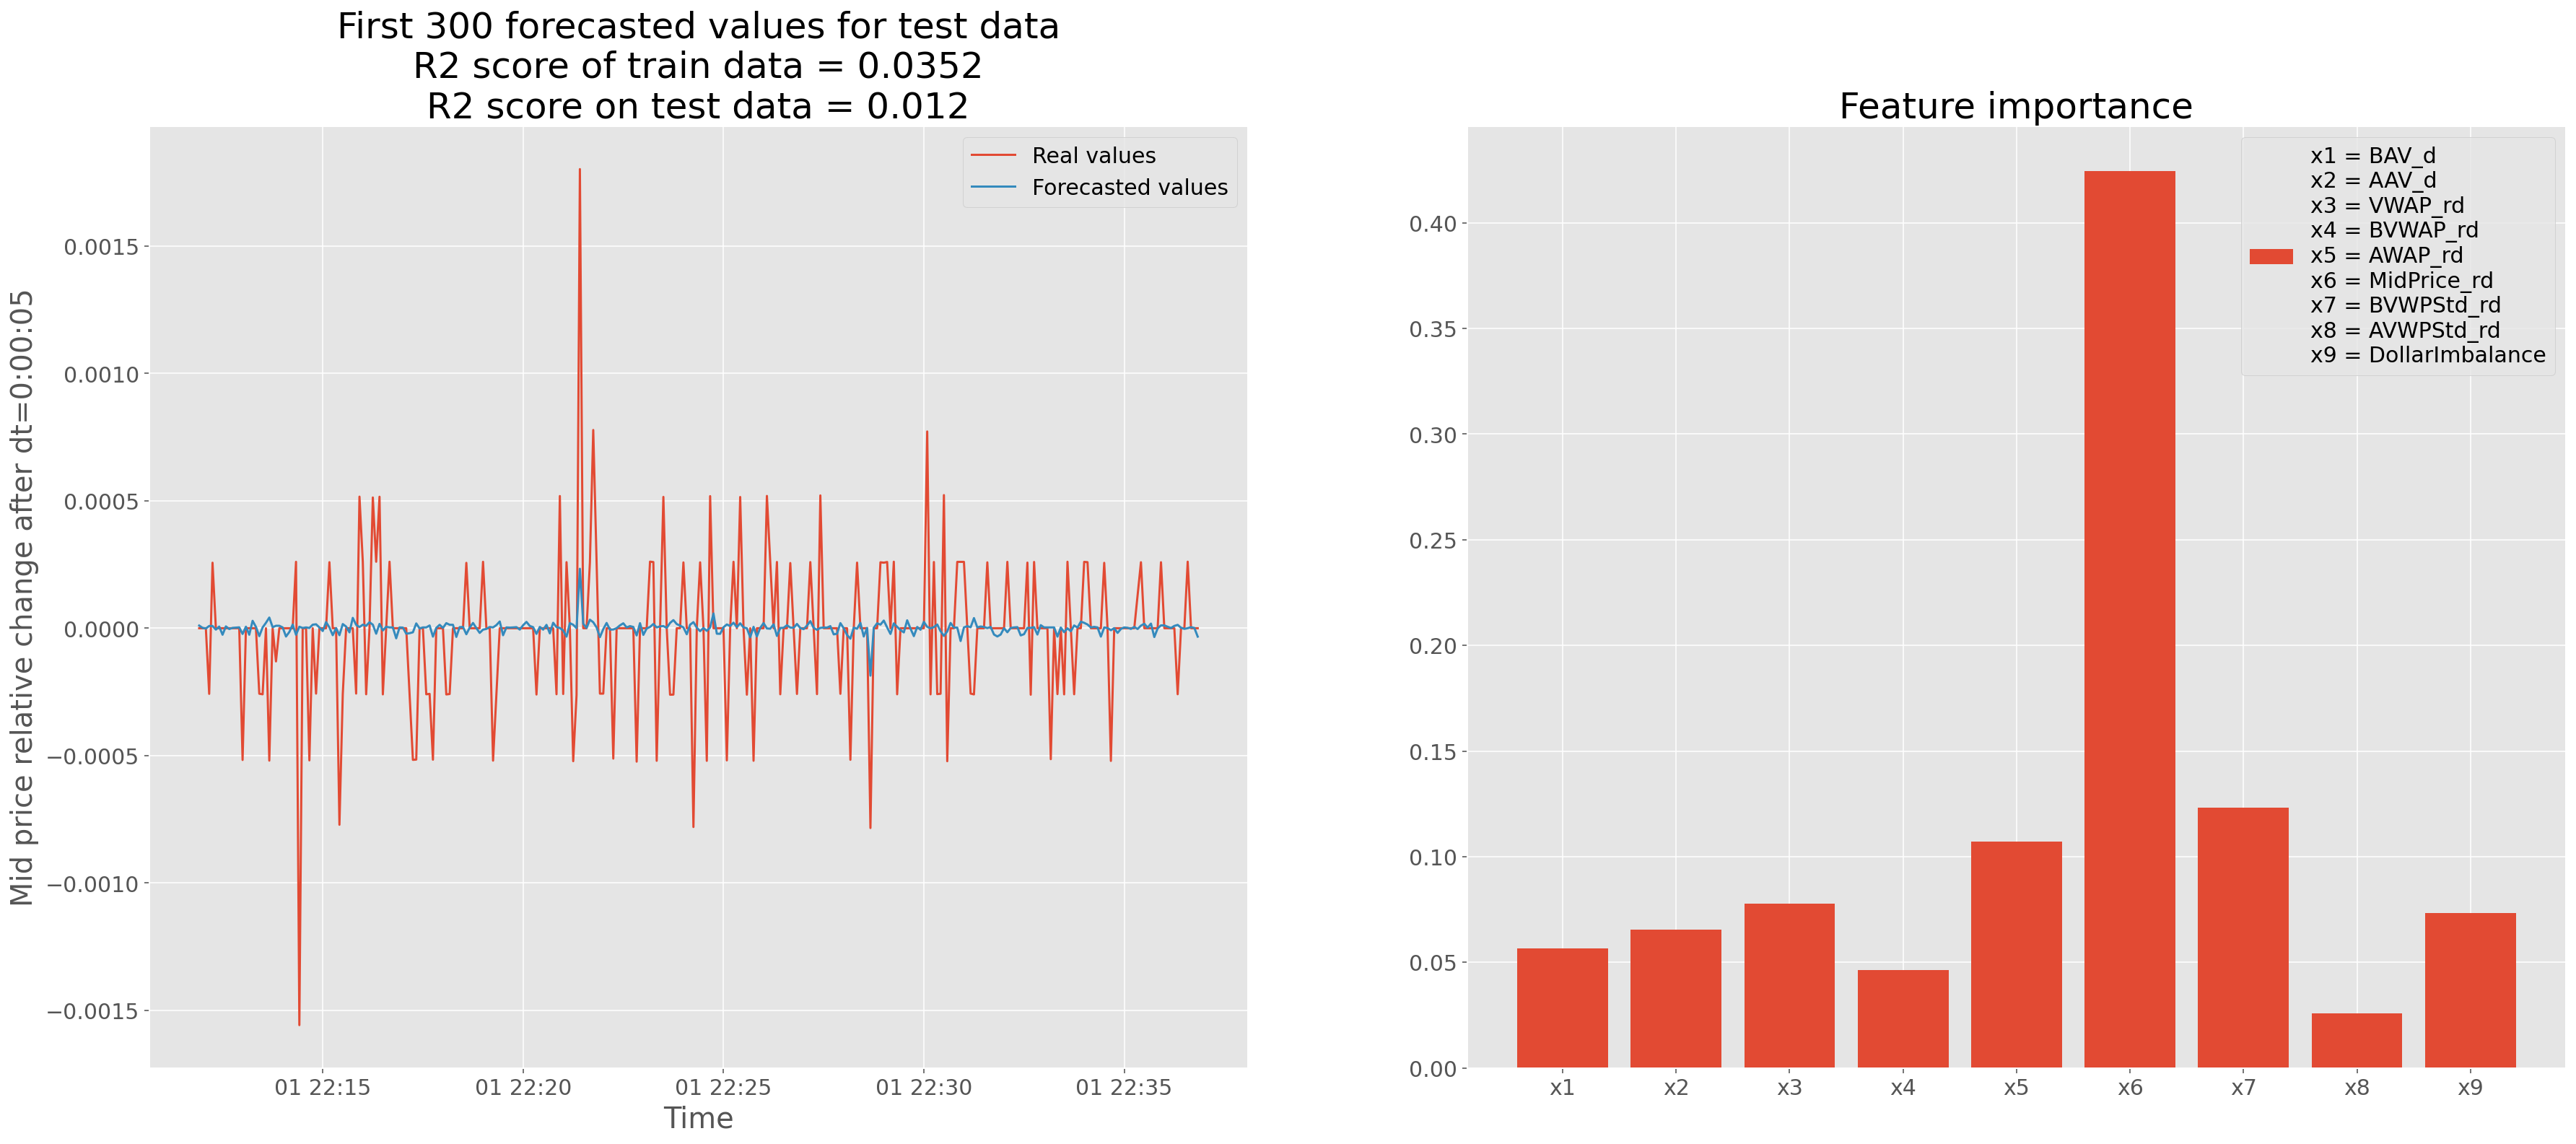

In [17]:
timedelta = datetime.timedelta(seconds=5)
validation_res = validate_model_for_timedelta(timedelta)
plot_results_for_validated_model(validation_res, timedelta)

## 30 seconds

  0%|          | 0/36 [00:00<?, ?it/s]

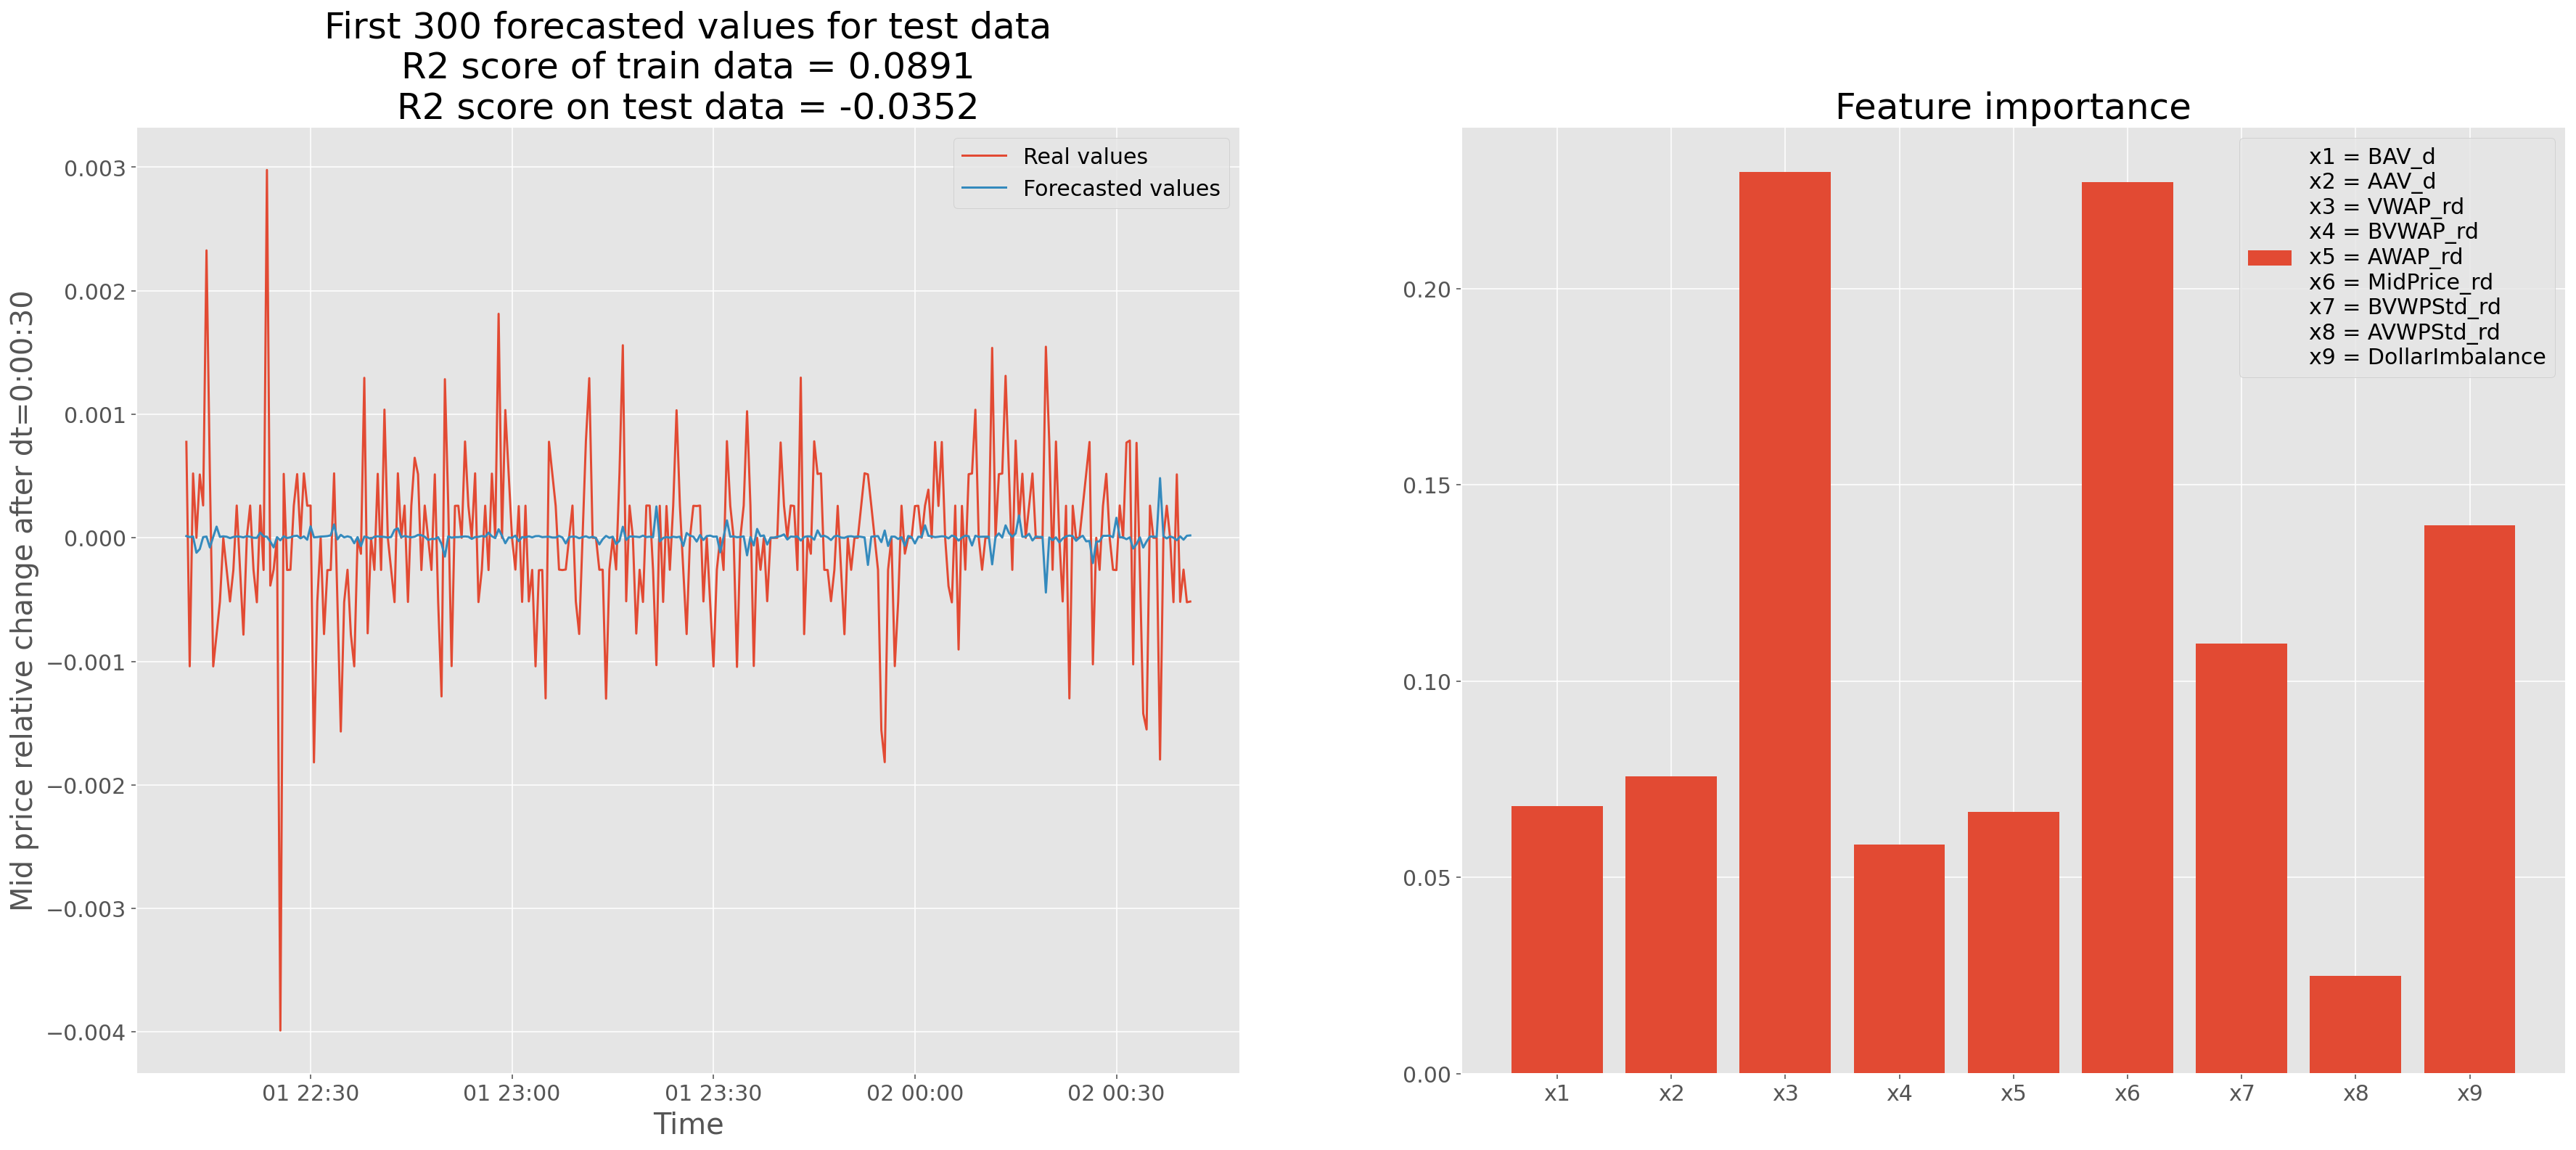

In [18]:
timedelta = datetime.timedelta(seconds=30)
validation_res = validate_model_for_timedelta(timedelta)
plot_results_for_validated_model(validation_res, timedelta)

## 1 minute

  0%|          | 0/36 [00:00<?, ?it/s]

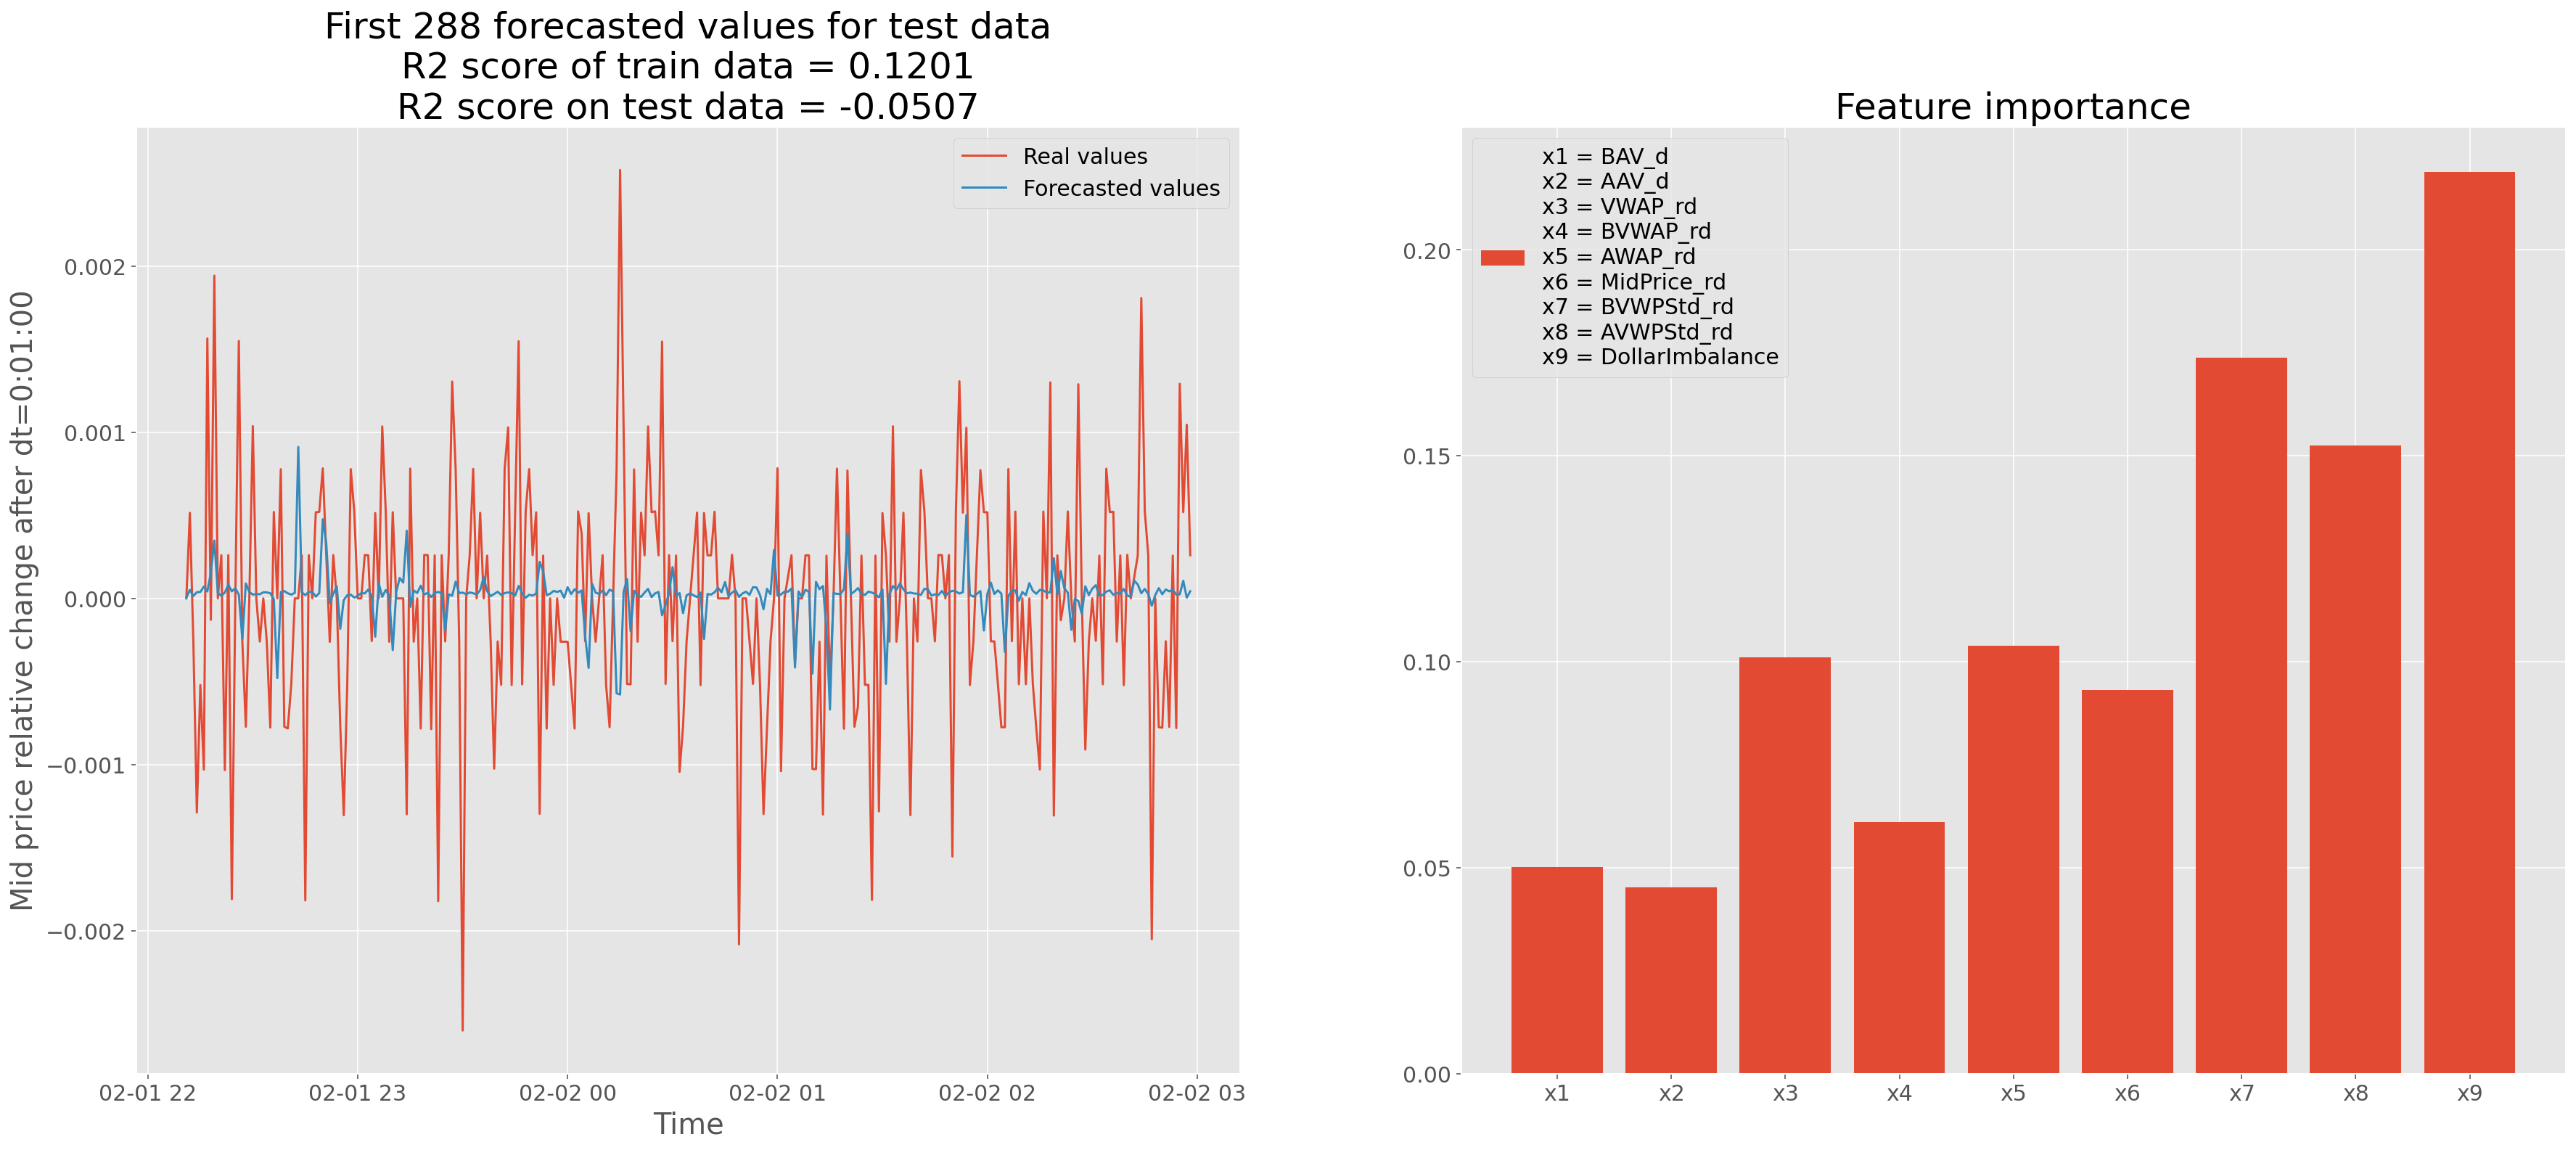

In [19]:
timedelta = datetime.timedelta(minutes=1)
validation_res = validate_model_for_timedelta(timedelta)
plot_results_for_validated_model(validation_res, timedelta)

# 4. Conclusion
It seems that the set of features extracted from the order book does not work at all in terms of forecast of the mid price change. And it doesn't matter which time horizon is chosen. But still let's analyze the results and speculate about what are the findings and what we could do further.

#### Why results are poor?
If we take a close look at the graph of the mid price change, we can see that the mid price almost doesn't change in short term, and that the volatility grows if the time horizon increases. It is not a huge finding because it is natural behavior of the price as a stochastic process. But it explains why results are better for the short time horizons: the model forecasts zero price change almost always. But when the model finally tries to predict non-zero change it usully fails. 
  
Therefore, we can say that used information from the order book is probably not enough for determining whether the price will change or not.

#### What can be done to improve results?
First, one of the reasons of bad results may be that we didn't take into account the history of the order book change. We took only the current state of the order book and calculated the change of its metrics in respect to the previous state. The obvious solution is to include some number of lags of the features into the model and validate this number as a hyperparameter.

Second, as it is stated in the previous paragraph, it is possible that we didn't extract enough information from the order book. For example, we could calculate more moments of volume weighted price (third, fourth, ...). Or we could calculate something like volume weighted covariance between bid and asks.

Finally, the Random Forest model might be the wrong choice. The main disadvantage of the Random Forest is that it can't predict values beyound the range of the training dataset. Hence, the problem of heteroscedasticity in the returns can become crucial for this algorithm. Perhaps, one of the further direction can be to try a different model.